Regression in real state 
========================

A partir de um dataset com dados de imóveis (metragem, cidade, bairro, quartos, etc), queremos prever o valor de cada registro usando redes neurais.

O dataset foi obtido a partir de _webscrapping_ em sites de publicação de anúncios 

## Imports

In [4]:
%load_ext autoreload
%autoreload 2

from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math 

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import sys
import platform

sys.path.insert(1, '../')

from src.plot import plot_heatmap
from src.train import get_all_subsets, results_regression


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config

In [2]:
# Evita mostrar números em formato científico (para melhor visualização)
np.set_printoptions(suppress=True)

# tamanhos padrão e visualização de plots
PLOT_WIDE = (14,7)
PLOT_MEDIUM = (10,8)
sns.set_style("darkgrid")

## Load data

In [7]:
WIN = r'C:\Users\psebastianv\dev\python\projetos-e-testes\other_python\zap-project\results\imoveis_data.csv'
LNX = r'./../../../../../python/other_python/zap-project/results/imoveis_data.csv'
data = pd.read_csv(WIN if platform.platform().startswith("Windows") else LNX)

In [8]:
data.shape

(18065, 12)

In [9]:
data.head()

,Unnamed: 0,id,size,rooms,wc,garage_spots,price,neighborhood,city,update_time,price_sqm,link
0,0.0,2528927815,130,3,3,2,2550000,Cabo Branco,João Pessoa,2023-08-16 19:33:46,19615.384615,NaN
1,1.0,2641054378,102,3,4,0,777695,Altiplano Cabo Branco,João Pessoa,2023-08-16 19:33:46,7624.460784,NaN
2,2.0,2617664208,66,3,1,1,755000,Ponta do Seixas,João Pessoa,2023-08-16 19:33:46,11439.393939,NaN
3,3.0,2612089563,108,3,3,1,375000,Tambaú,João Pessoa,2023-08-16 19:33:46,3472.222222,NaN
4,4.0,2530653710,57,2,2,1,178000,Ernesto Geisel,João Pessoa,2023-08-16 19:33:46,3122.807018,NaN


## Preprocessing

In [10]:
# fields numbers
list(enumerate(data.columns))

[(0, 'Unnamed: 0'),
 (1, 'id'),
 (2, 'size'),
 (3, 'rooms'),
 (4, 'wc'),
 (5, 'garage_spots'),
 (6, 'price'),
 (7, 'neighborhood'),
 (8, 'city'),
 (9, 'update_time'),
 (10, 'price_sqm'),
 (11, 'link')]

In [11]:
# Limpar colunas desnecessárias 
data.drop(data.columns[[0, 1, 5, 8, 9, 10, 11]], axis=1, inplace=True)

In [12]:
data.head()

,size,rooms,wc,price,neighborhood
0,130,3,3,2550000,Cabo Branco
1,102,3,4,777695,Altiplano Cabo Branco
2,66,3,1,755000,Ponta do Seixas
3,108,3,3,375000,Tambaú
4,57,2,2,178000,Ernesto Geisel


In [13]:
# missing values
data.isna().sum()

size            0
rooms           0
wc              0
price           0
neighborhood    0
dtype: int64

In [14]:
# Duplicates
data.drop_duplicates(keep='first', inplace=True)
data.duplicated().sum()

0

In [15]:
# nas características rooms, wc e garage_spots temos alguns valores não numéricos que indicam, por exemplo 2-3 \
# vamos rodar uma função para calcular a média desses valores e ter um resultado mais acurado 
data.rooms.unique()

array(['3', '2', '4', '20', '1', '5', '17', '6', '1 - 2', '2 - 3', '8',
       '13', '3 - 4'], dtype=object)

In [16]:
# Tratamento de valores numéricos que estão constando como str
# por exemplo: rooms nem sempre é número: 1 - 2

def update_data(i):
    output = None
    try:
        output = int(i)
    except:
        output = np.array(i.split(' - ')).astype(int).mean()
    
    return output

assert update_data('1') == 1, 'Não foi possível castear to int'
assert update_data('2 - 3') == 2.5, 'Não foi possível castear to int'


In [17]:
# Atualizar 3 colunas
for col in list(data.iloc[:, :4].select_dtypes('object').columns):
    data[col] = data[col].map(lambda x : update_data(x)).astype(float)

data.dtypes, data.head()

(size              int64
 rooms           float64
 wc              float64
 price             int64
 neighborhood     object
 dtype: object,
    size  rooms   wc    price           neighborhood
 0   130    3.0  3.0  2550000            Cabo Branco
 1   102    3.0  4.0   777695  Altiplano Cabo Branco
 2    66    3.0  1.0   755000        Ponta do Seixas
 3   108    3.0  3.0   375000                 Tambaú
 4    57    2.0  2.0   178000         Ernesto Geisel)

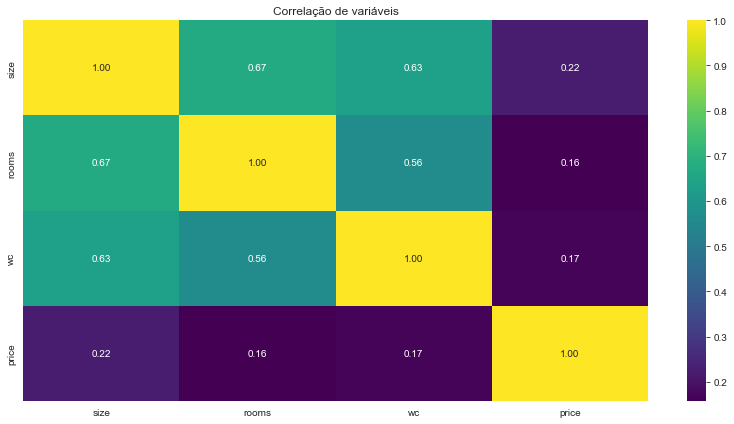

In [18]:
plot_heatmap(data.corr(numeric_only=True), \
             'Correlação de variáveis')

In [19]:
data.head()

,size,rooms,wc,price,neighborhood
0,130,3.0,3.0,2550000,Cabo Branco
1,102,3.0,4.0,777695,Altiplano Cabo Branco
2,66,3.0,1.0,755000,Ponta do Seixas
3,108,3.0,3.0,375000,Tambaú
4,57,2.0,2.0,178000,Ernesto Geisel


In [20]:
# Aplicando one-hot encoding na coluna 'neighborhood'
data = pd.get_dummies(data, columns=['neighborhood'], prefix='neighborhood', drop_first=True)

In [21]:
data.isna().sum().sum()

0

## Particionamento da base

In [22]:
y = data['price']
X = data.drop('price', axis=1)

In [23]:
# Normalizar
y /= np.max(y)
X /= np.max(X, axis=0)

In [24]:
X_train, X_val, X_test, y_train, y_val, y_test = get_all_subsets(X, y)

In [25]:
print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)
print('y_test: ', y_test.shape)


X_train:  (9568, 152)
X_val:  (2392, 152)
X_test:  (2990, 152)
y_train:  (9568,)
y_val:  (2392,)
y_test:  (2990,)


## Treinamento, definição de arquitetura

In [26]:
dropout_pct = 0.3
shape = (X_train.shape[1],)

display(shape)

model = Sequential()
model.add(Dense(units=512, activation='relu', input_shape=shape))
model.add(Dropout(dropout_pct))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(dropout_pct))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(dropout_pct))

model.add(Dense(units=1))

model.summary()

(152,)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               78336     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

## Definição de otimizadores

In [27]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [28]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, \
                   patience=10, verbose=1, mode='auto')

historico = model.fit(X_train,
                      y_train,
                      epochs=1000,
                      batch_size=32,
                      verbose=1,
                      validation_data=(X_val, y_val),
                      callbacks=[es])


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float64).

In [ ]:
y_pred = model.predict(X_test)

107/107 [==============================] - 0s 966us/step


## Avaliação do modelo

In [ ]:
results_regression(y_test, y_pred.flatten(), True)

MSE: 0.0001803024715962548
Erro médio quadrático (RMSE): 0.013427675584264567
Erro médio absoluto (MAE): 0.00401786171934225
Erro de porcentagem absoluta média (MAPE): 1.0
R2 Score: -0.09833872858413994


(0.0001803024715962548,
 0.013427675584264567,
 0.00401786171934225,
 1.0,
 -0.09833872858413994)

In [ ]:
results = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred.flatten()
    })

results['diff'] = y_test/y_pred.flatten()
display(results.sample(10), results['diff'].mean())

,y_test,y_pred,diff
6165,0.007088,0.004072,1.740797
7356,0.021769,0.005658,3.847156
15830,0.002374,0.004444,0.534245
11054,0.006054,0.004135,1.464339
20645,0.004755,0.005196,0.915102
13570,0.017007,0.004012,4.239414
5928,0.002381,0.004151,0.573570
2567,0.005102,0.004989,1.022675
16380,0.005612,0.004938,1.136510
20129,0.008844,0.005516,1.603323


0.8681392524716569